In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc

import species

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

## Quenched equilibrium

In [16]:
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_', n_params=29
    )
posterior_2, bestfit_2, PT_2, Chem_2, int_contr_em_2, int_contr_em_per_order_2, int_opa_cloud_2, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res
del res

pRT_atm_2 = af.pickle_load(
    './retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_data/pRT_atm_broad.pkl'
    )
pRT_atm_2.params = bestfit_params_2['params']

magnitudes = {
    #'GAIA/GAIA.G': (18.598427, 0.003844), 
    '2MASS/2MASS.J': (13.25, 0.03), # Dupuy et al. (2012)
    '2MASS/2MASS.H': (12.20, 0.02), 
    '2MASS/2MASS.Ks': (11.56, 0.02), 
    #'MKO/MKO.K': (11.551, 0.024), 
    'WISE/WISE.W1': (10.77, 0.02), # Gagne et al. (2015)
    'WISE/WISE.W2': (10.21, 0.02), 
}

  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_.txt
(3935, 29)


3397.947969514388


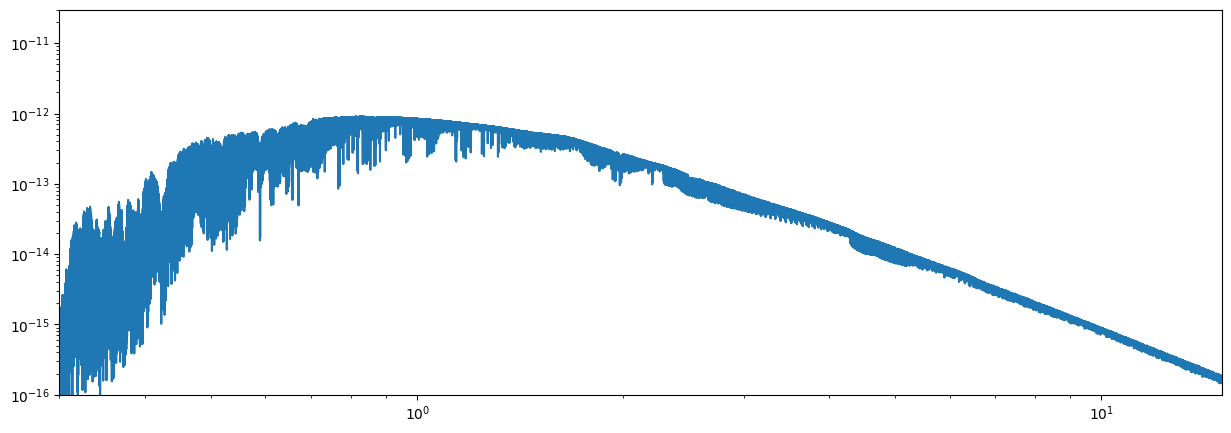

In [27]:
BT_SETTL_wave, BT_SETTL_flux = np.loadtxt('./data/ssap.txt').T

BT_SETTL_wave *= 1e-4 # convert from [A] to [um]

BT_SETTL_flux /= 1e-4 # convert from [erg/s/cm2/A] to [erg/s/cm2/um]
BT_SETTL_flux /= (1e-2)**2 # convert from [erg/s/cm2/um] to [erg/s/m2/um]
BT_SETTL_flux *= 1e-7 # convert from [erg/s/m2/um] to [W/m2/um]

print(
    (np.trapz(BT_SETTL_flux, x=BT_SETTL_wave) / (5.67051e-8))**(1/4)
)
BT_SETTL_flux *= (bestfit_params_2['params']['R_p']*nc.r_jup_mean / (1e3/bestfit_params_2['params']['parallax']*nc.pc))**2

plt.figure(figsize=(15,5))
plt.plot(BT_SETTL_wave, BT_SETTL_flux)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.3,15)
plt.ylim(1e-16,3e-11)
#plt.ylim(1e-1,1e7)
plt.show()

In [ ]:
pRT_atm = Radtrans(
    line_species=[
        'CO_12_HITEMP', 
        'CO_13_HITEMP', 
        'H2O_Exomol', 
        'CH4', 
        'NH3', 
        'CO2', 
        'HCN', 
        #'FeH', 
        #'H2S', 
        ], 
    rayleigh_species=['H2', 'He'], 
    continuum_opacities=['H2-H2', 'H2-He'], 
    wlen_bords_micron=[0.3,15], 
    )

pRT_atm.setup_opa_structure(PT_2.pressure)

In [ ]:
import petitRADTRANS.poor_mans_nonequ_chem as pm

species_pRT_names = {
    'CO': 'CO_12_HITEMP', 
    '13CO': 'CO_13_HITEMP', 
    'H2O': 'H2O_Exomol', 
    'CH4': 'CH4', 
    'NH3': 'NH3', 
    'CO2': 'CO2', 
    'HCN': 'HCN', 
    #'FeH': 'FeH', 
    #'H2S': 'H2S', 
    'H2': 'H2', 
    'He': 'He', 
    }

def quench_carbon_chemistry(params, pressure, temperature):

    CO = params['C/O']
    FeH = params['Fe/H']
    P_quench = params['P_quench']
    C_ratio = params['C_ratio']

    pm_mass_fractions = pm.interpol_abundances(
        CO*np.ones_like(pressure), 
        FeH*np.ones_like(pressure), 
        temperature, 
        pressure
        )

    # Layers to be replaced by a constant abundance
    mask_quenched = (pressure < P_quench)

    unquenched_mass_fractions = {}

    for i, species_i in enumerate(['CO', 'CH4', 'H2O']):
        
        # Store the unquenched abundance profiles
        #line_species_i = self.read_species_info(['12CO', 'CH4', 'H2O'][i], 'pRT_name')
        line_species_i = species_pRT_names[species_i]
        unquenched_mass_fractions[line_species_i] = np.copy(pm_mass_fractions[species_i])

        # Own implementation of quenching, using interpolation
        mass_fraction_i = pm_mass_fractions[species_i]
        mass_fraction_i[mask_quenched] = np.interp(P_quench, xp=pressure, fp=mass_fraction_i)
        pm_mass_fractions[species_i] = mass_fraction_i

    mass_fractions = {
        'MMW': pm_mass_fractions['MMW'], 

        'CO_12_HITEMP': (1 - C_ratio*(13+16)/(12+16)) * pm_mass_fractions['CO'], 
        'CO_13_HITEMP': C_ratio*(13+16)/(12+16) * pm_mass_fractions['CO'], 

        'H2O_Exomol': pm_mass_fractions['H2O'], 
        'CH4': pm_mass_fractions['CH4'], 
        'NH3': pm_mass_fractions['NH3'], 
        'CO2': pm_mass_fractions['CO2'], 
        'HCN': pm_mass_fractions['HCN'], 
        #'FeH': pm_mass_fractions['FeH'], 
        #'H2S': pm_mass_fractions['H2S'], 
        'H2': pm_mass_fractions['H2'], 
        'He': pm_mass_fractions['He'], 
        }

    return mass_fractions, unquenched_mass_fractions

from tqdm import tqdm
def get_flux_envelope(bestfit_params, posterior, PT, Chem):

    flux_envelope = []
    scaled_flux_envelope = []

    params = bestfit_params.copy()

    for i, sample in enumerate(tqdm(posterior[:200])):
        
        params['R_p'] = sample[8]
        params['log_g'] = sample[9]
        params['epsilon_limb'] = sample[10]
        params['vsini'] = sample[11]
        params['rv'] = sample[12]
        
        params['opa_base_gray'] = 10**sample[13]
        params['P_base_gray'] = 10**sample[14]
        params['f_sed_gray'] = sample[15]

        params['C/O'] = sample[16]
        params['Fe/H'] = sample[17]
        params['P_quench'] = 10**sample[18]
        params['C_ratio'] = 10**sample[19]

        params['T_0'] = sample[21]
        params['T_1'] = sample[22]
        params['T_2'] = sample[23]
        params['T_3'] = sample[24]
        params['T_4'] = sample[25]
        params['T_5'] = sample[26]
        params['T_6'] = sample[27]
        
        params['d_log_P_01'] = sample[28]
        params['log_P_knots'] = np.array([
            -6.0, 
            2.0-params['d_log_P_45']-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_01'], 
            2.0
            ])
        params['P_knots'] = 10**params['log_P_knots']
        
        params['T_knots'] = np.array([
            params['T_6'], 
            params['T_5'], 
            params['T_4'], 
            params['T_3'], 
            params['T_2'], 
            params['T_1'], 
            #params['T_0'], 
            ])


        # Compute the PT profile
        temperature = PT(params)

        
        mass_fractions, _ = quench_carbon_chemistry(params, PT_2.pressure, temperature)

        pRT_atm_2.params = params

        # Generate the pRT model spectrum 
        pRT_atm.calc_flux(
            temperature, 
            mass_fractions, 
            gravity=10**params['log_g'], 
            mmw=mass_fractions['MMW'], 
            give_absorption_opacity=pRT_atm_2.gray_cloud_opacity, 
            )
        wave = nc.c / pRT_atm.freq
        flux = pRT_atm.flux

        # Convert [erg cm^{-2} s^{-1} Hz^{-1}] -> [erg cm^{-2} s^{-1} cm^{-1}]
        flux *= nc.c / (wave**2)

        # Convert [erg cm^{-2} s^{-1} cm^{-1}] -> [erg cm^{-2} s^{-1} nm^{-1}]
        flux /= 1e7

        # Convert [erg cm^{-2} s^{-1} nm^{-1}] -> [W cm^{-2} nm^{-1}]
        flux *= 1e-7

        # Convert [W cm^{-2} nm^{-1}] -> [W m^{-2} nm^{-1}]
        flux /= (1e-2)**2

        # Convert [W m^{-2} nm^{-1}] -> [W m^{-2} um^{-1}]
        flux /= 1e-3

        # Convert [cm] -> [nm]
        #wave *= 1e7

        # Convert [cm] -> [um]
        wave *= 1e4

        flux_envelope.append(flux)

        # Convert to observation by scaling with planetary radius
        scaled_flux_envelope.append(flux*(params['R_p']*nc.r_jup_mean / (1e3/params['parallax']*nc.pc))**2)

        #if i == 500:
        #    break

    return wave, np.array(flux_envelope), np.array(scaled_flux_envelope)

wave, flux_envelope, scaled_flux_envelope = get_flux_envelope(bestfit_params_2['params'], posterior_2, PT_2, Chem_2)

In [ ]:
q = 0.5 + 1/100 * np.array([-99.7,-95,-68,0,68,95,99.7])/2

flux_conf_interval = np.quantile(flux_envelope, q=q, axis=0)
scaled_flux_conf_interval = np.quantile(scaled_flux_envelope, q=q, axis=0)

synth_flux_envelope = {}
synth_flux_conf_interval = {}
for key, val in magnitudes.items():
    synphot = species.SyntheticPhotometry(key)

    synth_flux_envelope[key] = []
    
    for flux_i in scaled_flux_envelope:
        synth_flux_i, _ = synphot.spectrum_to_flux(wave, flux_i)
        synth_flux_envelope[key].append(synth_flux_i)

    synth_flux_conf_interval[key] = np.quantile(np.array(synth_flux_envelope[key]), q=q)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax.fill_between(wave, scaled_flux_conf_interval[2], scaled_flux_conf_interval[-3], color='C0', ec='none')
ax.fill_between(wave, scaled_flux_conf_interval[1], scaled_flux_conf_interval[-2], color='C0', alpha=0.5, ec='none')
ax.fill_between(wave, scaled_flux_conf_interval[0], scaled_flux_conf_interval[-1], color='C0', alpha=0.5, ec='none')

colors = ['C1', 'C1', 'C1', 'r', 'r']
for i, (key, val) in enumerate(magnitudes.items()):
        
    filt = species.ReadFilter(key)
    synphot = species.SyntheticPhotometry(key)
    int_flux, error = synphot.magnitude_to_flux(val[0], error=val[1])

    a, _, _ = ax.errorbar(
        filt.mean_wavelength(), int_flux, yerr=error, 
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
        color=colors[i], elinewidth=3, marker='s', label=f'{key}',
        )
    
    #synth_flux, _ = synphot.spectrum_to_flux(wave, flux*((R_p*nc.r_jup_mean) / (1e3/parallax*nc.pc))**2)
    #ax.errorbar(
    #    filt.mean_wavelength(), synth_flux, yerr=error, 
    #    xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
    #    color=a.get_color(), alpha=0.5
    #    )
    ax.errorbar(
        filt.mean_wavelength(), synth_flux_conf_interval[key][3], 
        #yerr=np.abs(synth_flux_conf_interval[key][[1,-2]][:,None] - synth_flux_conf_interval[key][3]),  
        yerr=np.abs(synth_flux_conf_interval[key][[2,-3]][:,None] - synth_flux_conf_interval[key][3]),  
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
        color='b'
        )
    
ax.legend(loc='upper right')
    
ax.set(
    yscale='log', xscale='log', 
    #xlim=(1,6), ylim=(3e-16,1e-11), 
    xlim=(0.3,15), ylim=(1e-16,3e-11), 
    xlabel=r'Wavelength ($\mu$m)', 
    ylabel=r'$F_\lambda\ (\mathrm{W\ m^{-2}}\ \mu\mathrm{m^{-1}})$', 
    )
plt.savefig('./plots/photometry_comparison.pdf')
plt.show()

In [ ]:
T_eff = []

for flux_i in flux_envelope:
    T_eff.append((np.trapz(flux_i, x=wave) / (5.67051e-8))**(1/4))

print(np.median(T_eff), np.std(T_eff))
plt.hist(T_eff, range=(1000,6000), bins=30)
plt.xlabel('T_eff')
plt.show()

## Fiducial model

In [ ]:
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_nominal_5/test_', n_params=32
    )
posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res
del res

pRT_atm_1 = af.pickle_load(
    './retrieval_outputs/DENIS_J0255_nominal_5/test_data/pRT_atm_broad.pkl'
    )
pRT_atm_1.params = bestfit_params_1['params']

magnitudes = {
    '2MASS/2MASS.J': (13.25, 0.03), # Dupuy et al. (2012)
    '2MASS/2MASS.H': (12.20, 0.02), 
    '2MASS/2MASS.Ks': (11.56, 0.02), 
    #'MKO/MKO.K': (11.551, 0.024), 
    'WISE/WISE.W1': (10.77, 0.02), # Gagne et al. (2015)
    'WISE/WISE.W2': (10.21, 0.02), 
}

In [ ]:
pRT_atm = Radtrans(
    line_species=[
        'CO_12_HITEMP', 
        'CO_13_HITEMP', 
        'H2O_Exomol', 
        'CH4', 
        'NH3', 
        'CO2', 
        'HCN', 
        ], 
    rayleigh_species=['H2', 'He'], 
    continuum_opacities=['H2-H2', 'H2-He'], 
    wlen_bords_micron=[0.3,15], 
    )

pRT_atm.setup_opa_structure(PT_1.pressure)

In [ ]:
from tqdm import tqdm

def get_flux_envelope(bestfit_params, posterior, PT, Chem):

    flux_envelope = []
    scaled_flux_envelope = []

    params = bestfit_params.copy()

    for i, sample in enumerate(tqdm(posterior[:500])):
        
        params['R_p'] = sample[8]
        params['log_g'] = sample[9]
        params['epsilon_limb'] = sample[10]
        params['vsini'] = sample[11]
        params['rv'] = sample[12]
        
        params['opa_base_gray'] = 10**sample[13]
        params['P_base_gray'] = 10**sample[14]
        params['f_sed_gray'] = sample[15]

        params['T_0'] = sample[24]
        params['T_1'] = sample[25]
        params['T_2'] = sample[26]
        params['T_3'] = sample[27]
        params['T_4'] = sample[28]
        params['T_5'] = sample[29]
        params['T_6'] = sample[30]
        
        params['d_log_P_01'] = sample[31]
        params['log_P_knots'] = np.array([
            -6.0, 
            2.0-params['d_log_P_45']-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_34']-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_23']-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_12']-params['d_log_P_01'], 
            2.0-params['d_log_P_01'], 
            2.0
            ])
        params['P_knots'] = 10**params['log_P_knots']
        
        params['T_knots'] = np.array([
            params['T_6'], 
            params['T_5'], 
            params['T_4'], 
            params['T_3'], 
            params['T_2'], 
            params['T_1'], 
            #params['T_0'], 
            ])

        # Compute the PT profile
        temperature = PT(params)

        
        mass_fractions = {
            'H2': Chem_1.mass_fractions_posterior.get('H2')[i], 
            'He': Chem_1.mass_fractions_posterior.get('He')[i], 
            'CO_12_HITEMP': Chem_1.mass_fractions_posterior.get('CO_main_iso')[i], 
            'CO_13_HITEMP': Chem_1.mass_fractions_posterior.get('CO_36')[i], 
            'H2O_Exomol': Chem_1.mass_fractions_posterior.get('H2O_pokazatel_main_iso')[i], 
            'CH4': Chem_1.mass_fractions_posterior.get('CH4_hargreaves_main_iso')[i], 
            'NH3': Chem_1.mass_fractions_posterior.get('NH3_coles_main_iso')[i], 
            'CO2': Chem_1.mass_fractions_posterior.get('CO2_main_iso')[i], 
            'HCN': Chem_1.mass_fractions_posterior.get('HCN_main_iso')[i], 
            }

        pRT_atm_1.params = params

        # Generate the pRT model spectrum 
        pRT_atm.calc_flux(
            temperature, 
            mass_fractions, 
            gravity=10**params['log_g'], 
            mmw=Chem.mass_fractions_posterior['MMW'][i], 
            give_absorption_opacity=pRT_atm_1.gray_cloud_opacity, 
            )
        wave = nc.c / pRT_atm.freq
        flux = pRT_atm.flux

        # Convert [erg cm^{-2} s^{-1} Hz^{-1}] -> [erg cm^{-2} s^{-1} cm^{-1}]
        flux *= nc.c / (wave**2)

        # Convert [erg cm^{-2} s^{-1} cm^{-1}] -> [erg cm^{-2} s^{-1} nm^{-1}]
        flux /= 1e7

        # Convert [erg cm^{-2} s^{-1} nm^{-1}] -> [W cm^{-2} nm^{-1}]
        flux *= 1e-7

        # Convert [W cm^{-2} nm^{-1}] -> [W m^{-2} nm^{-1}]
        flux /= (1e-2)**2

        # Convert [W m^{-2} nm^{-1}] -> [W m^{-2} um^{-1}]
        flux /= 1e-3

        # Convert [cm] -> [nm]
        #wave *= 1e7

        # Convert [cm] -> [um]
        wave *= 1e4

        flux_envelope.append(flux)

        # Convert to observation by scaling with planetary radius
        scaled_flux_envelope.append(flux*(params['R_p']*nc.r_jup_mean / (1e3/params['parallax']*nc.pc))**2)

        #if i == 500:
        #    break

    return wave, np.array(flux_envelope), np.array(scaled_flux_envelope)

wave, flux_envelope, scaled_flux_envelope = get_flux_envelope(bestfit_params_1['params'], posterior_1, PT_1, Chem_1)

In [ ]:
q = 0.5 + 1/100 * np.array([-99.7,-95,-68,0,68,95,99.7])/2

flux_conf_interval = np.quantile(flux_envelope, q=q, axis=0)
scaled_flux_conf_interval = np.quantile(scaled_flux_envelope, q=q, axis=0)

synth_flux_envelope = {}
synth_flux_conf_interval = {}
for key, val in magnitudes.items():
    synphot = species.SyntheticPhotometry(key)

    synth_flux_envelope[key] = []
    
    for flux_i in scaled_flux_envelope:
        synth_flux_i, _ = synphot.spectrum_to_flux(wave, flux_i)
        synth_flux_envelope[key].append(synth_flux_i)

    synth_flux_conf_interval[key] = np.quantile(np.array(synth_flux_envelope[key]), q=q)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax.fill_between(wave, scaled_flux_conf_interval[2], scaled_flux_conf_interval[-3], color='C0', ec='none')
ax.fill_between(wave, scaled_flux_conf_interval[1], scaled_flux_conf_interval[-2], color='C0', alpha=0.5, ec='none')
ax.fill_between(wave, scaled_flux_conf_interval[0], scaled_flux_conf_interval[-1], color='C0', alpha=0.5, ec='none')

colors = ['C1', 'C1', 'C1', 'r', 'r']
for i, (key, val) in enumerate(magnitudes.items()):
        
    filt = species.ReadFilter(key)
    synphot = species.SyntheticPhotometry(key)
    int_flux, error = synphot.magnitude_to_flux(val[0], error=val[1])

    a, _, _ = ax.errorbar(
        filt.mean_wavelength(), int_flux, yerr=error, 
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
        color=colors[i], elinewidth=3, marker='s', label=f'{key}',
        )
    
    #synth_flux, _ = synphot.spectrum_to_flux(wave, flux*((R_p*nc.r_jup_mean) / (1e3/parallax*nc.pc))**2)
    #ax.errorbar(
    #    filt.mean_wavelength(), synth_flux, yerr=error, 
    #    xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
    #    color=a.get_color(), alpha=0.5
    #    )
    ax.errorbar(
        filt.mean_wavelength(), synth_flux_conf_interval[key][3], 
        #yerr=np.abs(synth_flux_conf_interval[key][[1,-2]][:,None] - synth_flux_conf_interval[key][3]),  
        yerr=np.abs(synth_flux_conf_interval[key][[2,-3]][:,None] - synth_flux_conf_interval[key][3]),  
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
        color='b'
        )
    
ax.legend(loc='upper right')
    
ax.set(
    yscale='log', xscale='log', 
    xlim=(1,6), ylim=(3e-16,1e-11), 
    xlabel=r'Wavelength ($\mu$m)', 
    ylabel=r'$F_\lambda\ (\mathrm{W\ m^{-2}}\ \mu\mathrm{m^{-1}})$', 
    )
plt.savefig('./plots/photometry_comparison.pdf')
plt.show()

In [ ]:
T_eff = []

for flux_i in flux_envelope:
    T_eff.append((np.trapz(flux_i, x=wave) / (5.67051e-8))**(1/4))

print(np.median(T_eff), np.std(T_eff))
plt.hist(T_eff, range=(1000,6000), bins=50)
plt.show()

In [ ]:
T_eff = []

fig, ax = plt.subplots(figsize=(15,5))
for i in range(len(flux_envelope)):
    ax.plot(wave, scaled_flux_envelope[i], c='k', lw=0.1)

    T_eff.append(
        (np.trapz(flux_envelope[i], x=wave) / (5.67051e-8))**(1/4)
        )

ax.set(yscale='log', xscale='log', xlim=(1,6))
plt.show()

print(np.median(T_eff), np.std(T_eff))

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(wave, flux*((R_p*nc.r_jup_mean) / (1e3/parallax*nc.pc))**2, c='k', lw=1)

for key, val in magnitudes.items():
        
    filt = species.ReadFilter(key)

    synphot = species.SyntheticPhotometry(key)
    int_flux, error = synphot.magnitude_to_flux(val[0], error=val[1])
    #print(int_flux, error)

    print(key, filt.wavelength_range())

    a, _, _ = ax.errorbar(
        filt.mean_wavelength(), int_flux, yerr=error, 
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength())
        )
    
    synth_flux, _ = synphot.spectrum_to_flux(wave, flux*((R_p*nc.r_jup_mean) / (1e3/parallax*nc.pc))**2)
    ax.errorbar(
        filt.mean_wavelength(), synth_flux, yerr=error, 
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
        color=a.get_color(), alpha=0.5
        )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1,6)
plt.show()

In [ ]:
plt.hist(T_eff)
plt.show()

In [ ]:
# Compute the emission spectrum
pRT_atm.calc_flux(
    PT_1.temperature, 
    mass_fractions, 
    gravity=gravity, 
    mmw=Chem_1.mass_fractions['MMW'], 
    give_absorption_opacity=pRT_atm_1.gray_cloud_opacity, 
    )
wave = nc.c / pRT_atm.freq
flux = pRT_atm.flux

# Convert [erg cm^{-2} s^{-1} Hz^{-1}] -> [erg cm^{-2} s^{-1} cm^{-1}]
flux *= nc.c / (wave**2)

# Convert [erg cm^{-2} s^{-1} cm^{-1}] -> [erg cm^{-2} s^{-1} nm^{-1}]
flux /= 1e7

# Convert [erg cm^{-2} s^{-1} nm^{-1}] -> [W cm^{-2} nm^{-1}]
flux *= 1e-7

# Convert [W cm^{-2} nm^{-1}] -> [W m^{-2} nm^{-1}]
flux /= (1e-2)**2

# Convert [W m^{-2} nm^{-1}] -> [W m^{-2} um^{-1}]
flux /= 1e-3

# Convert [cm] -> [nm]
#wave *= 1e7

# Convert [cm] -> [um]
wave *= 1e4

# Convert to observation by scaling with planetary radius
R_p = bestfit_params_1['params']['R_p']
parallax = bestfit_params_1['params']['parallax']
#flux *= (
#    (R_p*nc.r_jup_mean) / \
#    (1e3/parallax*nc.pc)
#    )**2

print('T_eff:')
print(
    (np.sum(flux[1:]*np.diff(wave)) / (5.67051e-8))**(1/4)
    )
print(
    (np.trapz(flux, x=wave) / (5.67051e-8))**(1/4)
    )

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(wave, flux*((R_p*nc.r_jup_mean) / (1e3/parallax*nc.pc))**2, c='k', lw=1)

for key, val in magnitudes.items():
        
    filt = species.ReadFilter(key)

    synphot = species.SyntheticPhotometry(key)
    int_flux, error = synphot.magnitude_to_flux(val[0], error=val[1])
    #print(int_flux, error)

    print(key, filt.wavelength_range())

    a, _, _ = ax.errorbar(
        filt.mean_wavelength(), int_flux, yerr=error, 
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength())
        )
    
    synth_flux, _ = synphot.spectrum_to_flux(wave, flux*((R_p*nc.r_jup_mean) / (1e3/parallax*nc.pc))**2)
    ax.errorbar(
        filt.mean_wavelength(), synth_flux, yerr=error, 
        xerr=np.abs(np.array(list(filt.wavelength_range()))[:,None] - filt.mean_wavelength()), 
        color=a.get_color(), alpha=0.5
        )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1,6)
plt.show()